In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree
import seaborn as sns
from scipy import stats

##添加隐藏代码的按钮
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

In [2]:
data=pd.read_csv('E:\\pydata\\fanjin\\jd_result.csv')

In [3]:
# 数据处理
dat=data
dat['num']=1
dat['flag_bad']=np.where(dat['label']=='GOOD',0,1)

In [6]:
dat.head()

,transport_id,DTI,loan_quality_gcnt,loan_quality_brate,gmv_min_val_cut,weight_time,AS_dispute_me,DSR_only_no_refund,gmv_last_6,gmv_last_mean_ratio,score,level,label,num,flag_bad
0,160598,0.095005,0,1,1,1.118904,0.00,False,2777778.20,0.798882,43,level_4,GOOD,1,0
1,160987,0.336425,1,0,0,1.200000,0.00,True,701202.06,1.330390,30,level_5,GOOD,1,0
2,161029,0.094538,3,0,0,0.936073,0.73,True,1163556.93,2.977863,68,level_3,GOOD,1,0
3,161055,0.083001,0,1,1,1.200000,0.05,True,6000000.00,0.163677,58,level_3,GOOD,1,0
4,161263,0.008332,2,0,0,1.002192,0.00,False,359249.50,1.026097,49,level_4,GOOD,1,0


In [7]:
a=dat['flag_bad']
print('好坏样本个数：')
a.value_counts()

好坏样本个数：


0    543
1     54
Name: flag_bad, dtype: int64

## IV value

In [83]:
def woe_single(DF,Y,X):
    if X.nunique()>11:
        r = 0
        bad=Y.sum()      #坏客户数(假设因变量列为1的是坏客户)
        good=Y.count()-bad  #好客户数
        n=5
        while np.abs(r) < 1:
            d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n,duplicates='drop')})
            d2 = d1.groupby('Bucket', as_index = False)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1
        d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
        d3['min']=d2.min().X    
        d3['max'] = d2.max().X
        d3['sum'] = d2.sum().Y
        d3['total'] = d2.count().Y
        d3['bad_rate'] = d2.mean().Y
        d3['group_rate']=d3['total']/(bad+good)
        d3['woe']=np.log((d3['bad_rate']/(1-d3['bad_rate']))/(bad/good))
        d3['iv']=(d3['sum']/bad-((d3['total']-d3['sum'])/good))*d3['woe']
        iv=d3['iv'].sum()
        if iv!=0.0 and len(d2)>1:
            d3['iv_sum']=iv
            woe=list(d3['woe'].round(6))
            cut=list(d3['min'].round(6))
            cut1=list(d3['max'].round(6))
            cut.append(cut1[-1]+1)
            x_woe=pd.cut(X,cut,right=False,labels=woe)
            return(iv,cut)
            #print(d3,'\ncut:\n',cut,'\nwoe:\n',woe,'\niv:\n',iv,'\nx_woe:\n',x_woe)
        else:
            dn1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.cut(X, 100)})
            dn2 = dn1.groupby('Bucket', as_index = False)
            dn3 = pd.DataFrame(dn2.X.min(), columns = ['min'])
            dn3['min']=dn2.min().X    
            dn3['max'] = dn2.max().X
            dn3['sum'] = dn2.sum().Y
            dn3['total'] = dn2.count().Y
            while (1):
                    if  (len(dn3)>4):
                        dn3_min_index = dn3[dn3.total == min(dn3.total)].index.values[0]
                        if (dn3_min_index!=0):    #最小值非第一行的情况
                            dn3.iloc[dn3_min_index-1, 1] =dn3.iloc[dn3_min_index, 1] 
                            dn3.iloc[dn3_min_index-1, 2] = dn3.iloc[dn3_min_index, 2] +dn3.iloc[dn3_min_index-1, 2]
                            dn3.iloc[dn3_min_index-1, 3] = dn3.iloc[dn3_min_index, 3] +dn3.iloc[dn3_min_index-1, 3]
                            dn3=dn3.drop([dn3_min_index])
                            dn3= dn3.reset_index(drop=True)
                        else:    #最小值是第一行的情况
                            dn3.iloc[dn3_min_index+1, 0] =dn3.iloc[dn3_min_index, 0] 
                            dn3.iloc[dn3_min_index+1, 2] = dn3.iloc[dn3_min_index, 2] +dn3.iloc[dn3_min_index+1, 2]
                            dn3.iloc[dn3_min_index+1, 3] = dn3.iloc[dn3_min_index, 3] +dn3.iloc[dn3_min_index+1, 3]
                            dn3=dn3.drop([dn3_min_index])
                            dn3= dn3.reset_index(drop=True)
                    else:
                        break
            dn3['bad_rate'] =dn3['sum']/dn3['total']
            dn3['group_rate']=dn3['total']/(bad+good)
            dn3['woe']=np.log((dn3['bad_rate']/(1-dn3['bad_rate']))/(bad/good))
            dn3['iv']=(dn3['sum']/bad-((dn3['total']-dn3['sum'])/good))*dn3['woe']
            
            iv=dn3['iv'].sum()
            dn3['iv_sum']=iv
            woe=list(dn3['woe'].round(6)) 
            cut=list(dn3['min'].round(6))
            cut1=list(dn3['max'].round(6))
            cut.append(cut1[-1]+1)
            x_woe=pd.cut(X,cut,right=False,labels=woe)
            return(iv,cut)
            #print(dn3,'\ncut\n',cut,'\nwoe\n',woe,'\niv\n',iv,'\nx_woe\n',x_woe)
    else : 
        bad=Y.sum()      #坏客户数
        good=Y.count()-bad  #好客户数
        d1 = pd.DataFrame({"X": X, "Y": Y})
        d2 = d1.groupby('X', as_index =True)
        d3 = pd.DataFrame()
        
        d3['sum'] = d2.sum().Y
        d3['total'] = d2.count().Y
        for c in range(d3.shape[0])[::-1]:
            if ((d3.iloc[c,1]-d3.iloc[c,0])==0) or (d3.iloc[c,0]==0):
                d3.iloc[c-1,0]=d3.iloc[c-1,0]+d3.iloc[c,0]
                d3.iloc[c-1,1]=d3.iloc[c-1,1]+d3.iloc[c,1]
                d3.drop(d3.index[c],inplace=True)
            else:
                continue
        
        d3['min']=d3.index  
        d3['max'] = d3.index
        d3['bad_rate'] =d3['sum']/d3['total']
        d3['group_rate']=d3['total']/(bad+good)
        d3['woe']=np.log((d3['bad_rate']/(1-d3['bad_rate']))/(bad/good))
        d3['iv']=(d3['sum']/bad-((d3['total']-d3['sum'])/good))*d3['woe']
        iv=d3['iv'].sum()
        d3['iv_sum']=iv
        d3=d3[['min','max','sum','total','bad_rate','group_rate','woe','iv','iv_sum']]
        
        
        woe=list(d3['woe'].round(6))
        cut=list(d3.index)
        x_woe=X.replace(cut,woe)
        return(iv,cut)
        #print(d3,'cut:\n',cut,'woe:\n',woe,'iv:\n',iv,'x_woe:\n',x_woe)

In [10]:
dat.columns

Index(['transport_id', 'DTI', 'loan_quality_gcnt', 'loan_quality_brate',
       'gmv_min_val_cut', 'weight_time', 'AS_dispute_me', 'DSR_only_no_refund',
       'gmv_last_6', 'gmv_last_mean_ratio', 'score', 'level', 'label', 'num',
       'flag_bad'],
      dtype='object')

In [79]:
woe_single(dat,dat['flag_bad'],dat['AS_dispute_me'])

(0.03781973426487279, [0.0, 0.16, 0.32, 0.48, 16.740000000000002])

In [80]:
col_list=['DTI', 'loan_quality_gcnt', 'loan_quality_brate','gmv_min_val_cut', 'weight_time','AS_dispute_me',
       'DSR_only_no_refund','gmv_last_6', 
       'gmv_last_mean_ratio', 'score', 'level', 'label']
#woe_single(dat,dat['flag_bad'],dat['AS_dispute_me'])

name=[]
iv=[]
cut=[]
count=[]
for i in col_list:
    name.append(i)
    iv.append(woe_single(dat,dat['flag_bad'],dat[i])[0])
    cut.append(woe_single(dat,dat['flag_bad'],dat[i])[1])
    count.append(len(woe_single(dat,dat['flag_bad'],dat[i])[1]))
iv_summary=pd.DataFrame({'name':name,'iv':iv,'cut':cut,'cnt':count})
iv_summary=iv_summary[['iv','name','cut','cnt']]
iv_summary.sort_values('iv',ascending=False)

,iv,name,cut,cnt
10,0.620055,level,"[level_1, level_2, level_3, level_4, level_5, ...",7
9,0.616861,score,"[2, 25, 50, 74, 100]",5
1,0.236881,loan_quality_gcnt,"[0, 1, 2, 3]",4
0,0.218698,DTI,"[0.0, 0.045271, 0.296591, 2.829173]",4
3,0.153973,gmv_min_val_cut,"[0, 1]",2
2,0.144168,loan_quality_brate,"[0, 1]",2
4,0.088497,weight_time,"[0.536986, 1.02137, 1.027945, 1.113973, 2.2]",5
6,0.050420,DSR_only_no_refund,"[False, True]",2
5,0.037820,AS_dispute_me,"[0.0, 0.16, 0.32, 0.48, 16.740000000000002]",5
7,0.029250,gmv_last_6,"[0.0, 360070.84, 1080844.75, 1925237.74, 60000...",5


## 单变量分析

In [53]:
# 等频分箱
def cut_go(dat,string,n):
    cutBox=dat
    cutBox=cutBox.sort_values(string)
    cutBox=cutBox.set_index(np.arange(1,len(cutBox[string])+1,1))
    
    sid=list(np.arange(1,len(cutBox[string])+1,(len(cutBox[string]))/n))
    sid[0]=-1
    sid.append(len(cutBox[string])+1)
    cutBox['cut']=pd.cut(cutBox.index,sid)
    
    return cutBox

In [57]:
# 等分画图
def go_pic(dat,obj,n):
    cut_obj=obj #替换字段#

    dat1=dat[[cut_obj,'flag_bad']]

    dat2=cut_go(dat1,cut_obj,n)
    dat2['num']=1
    dat2=dat2.sort_values(cut_obj)

    dat3=dat2.groupby('cut',as_index=False).agg({'flag_bad':sum,cut_obj:max,'num':sum})
    dat3['bad_rate']=dat3['flag_bad']/dat3['num']
    dat3=dat3.sort_values(cut_obj)

    cut_max=[]
    for i in np.arange(len(dat3[cut_obj])):
        cut_max.append(str(i)+'~~<='+str(round(dat3[cut_obj][i],2)))

    dat3['cut_max']=cut_max


    ## 可视化展示
    dat_plot=dat3

    dat_plot['X']=dat_plot['cut_max']
    dat_plot['Y']=dat_plot['bad_rate']
    dat_plot['Y2']=dat_plot['num']

    fig=plt.figure(figsize=(12,5))
    ax1=fig.add_subplot(1,1,1)
    ax1.bar(dat_plot['X'],dat_plot['Y2'],color='skyblue')
    #ax1.bar(dat_plot.X,dat_plot.Y3,color='b',bottom=dat_plot.Y)
    #ax1.set_ylim(0,30)
    ax1.set_ylabel('cnt',size=15)
    plt.xticks(rotation=45)

    ax2=ax1.twinx()
    ax2.plot(dat_plot['X'],dat_plot['Y'],'-',color='r')
    #ax2.set_ylim(0,1)
    ax2.set_ylabel(u'$rate$',size=15)
    plt.xticks(rotation=45)
    
    plt.title(cut_obj,size=20)

In [60]:
dat.dtypes

transport_id             int64
DTI                    float64
loan_quality_gcnt        int64
loan_quality_brate       int64
gmv_min_val_cut          int64
weight_time            float64
AS_dispute_me          float64
DSR_only_no_refund        bool
gmv_last_6             float64
gmv_last_mean_ratio    float64
score                    int64
level                   object
label                   object
num                      int64
flag_bad                 int32
dtype: object

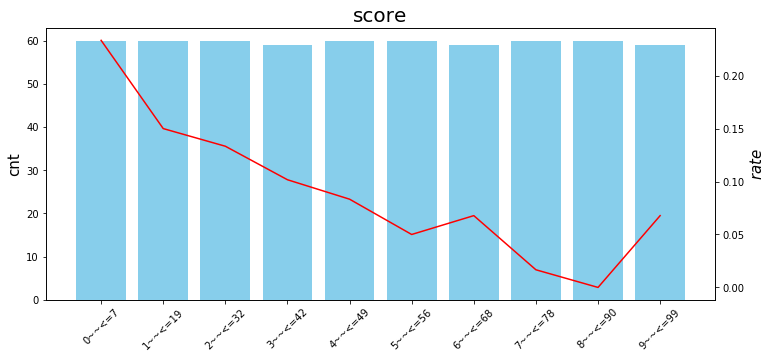

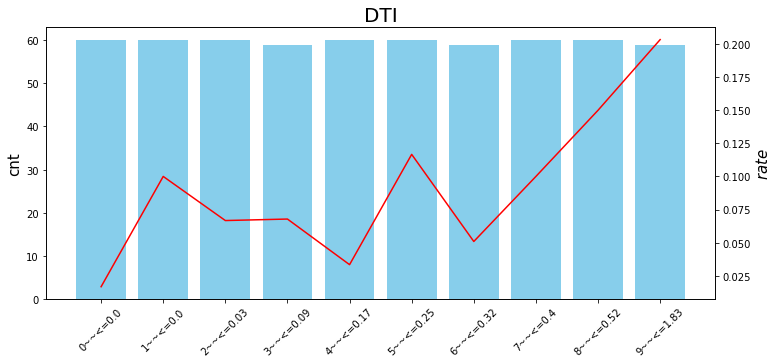

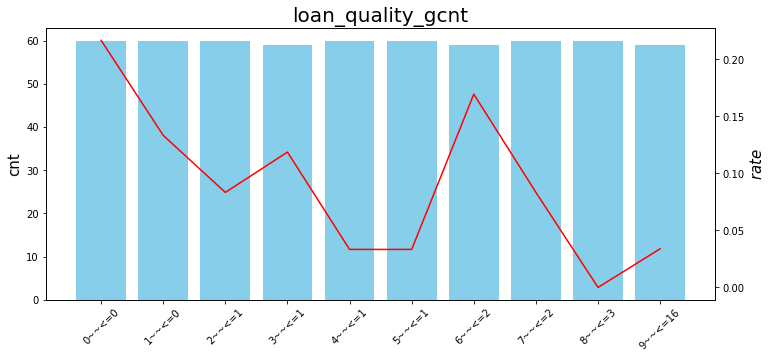

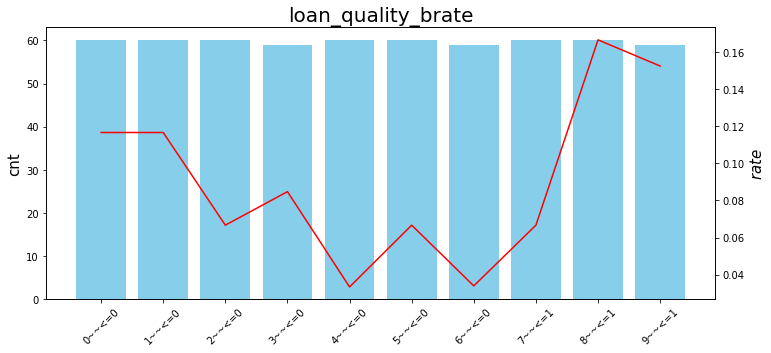

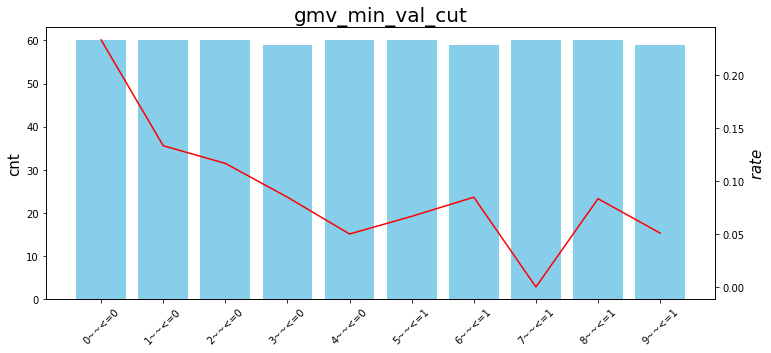

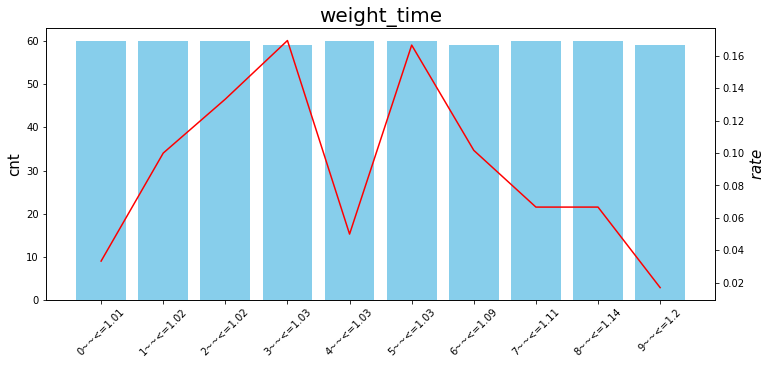

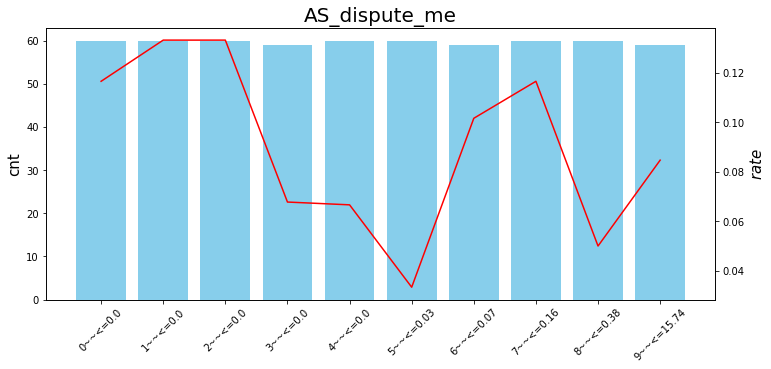

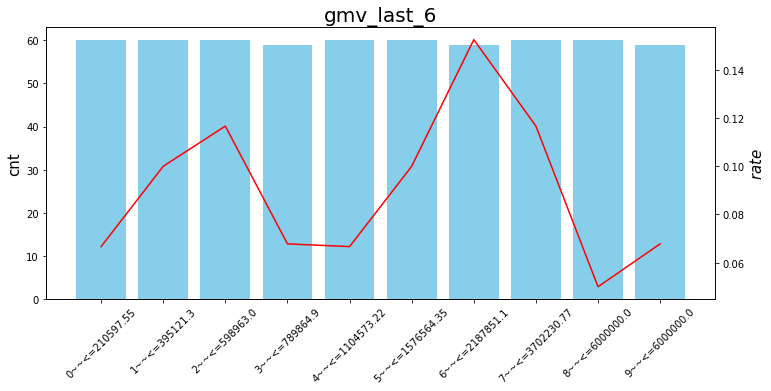

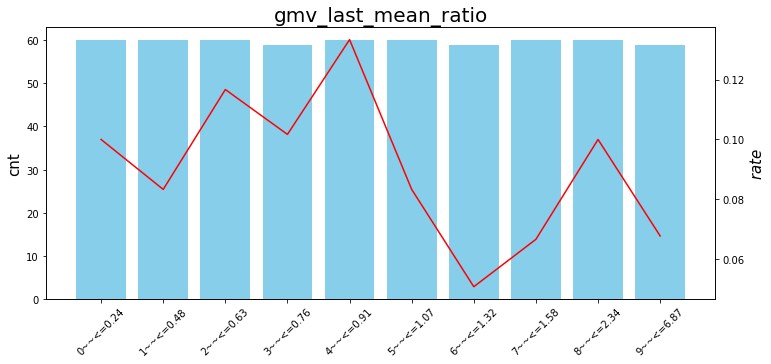

In [67]:
for i in ['score','DTI','loan_quality_gcnt','loan_quality_brate','gmv_min_val_cut','weight_time','AS_dispute_me','gmv_last_6','gmv_last_mean_ratio']:
    go_pic(dat,i,10)